In [182]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import os
import sys
import yfinance as yf

In [344]:
sp500 = yf.Ticker('^GSPC')
sp500 = sp500.history(start='2010-01-01', end='2023-10-01')

In [345]:
sp500.reset_index(inplace=True)
# let's convert the datetime to a date only object
sp500["Date"] = sp500["Date"].dt.date
sp500["Date"] = pd.to_datetime(sp500["Date"])


In [346]:
macro_econ = pd.read_csv(os.path.join("datasets", 'macroeconomics_data.csv'))
macro_econ["Date"] = pd.to_datetime(macro_econ["Date"])
macro_econ["Date"]

0      2010-01-01
1      2010-01-02
2      2010-01-03
3      2010-01-04
4      2010-01-05
          ...    
5017   2023-09-27
5018   2023-09-28
5019   2023-09-29
5020   2023-09-30
5021   2023-10-01
Name: Date, Length: 5022, dtype: datetime64[ns]

In [347]:
sp500 = sp500.merge(macro_econ, on="Date", how="left")
sp500

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,CPI,Unemployment Rate,10-year Treasury
0,2010-01-04,6.461439,6.493833,6.429651,6.478998,493729600,0.0,0.0,-0.156725,9.8,3.85
1,2010-01-05,6.496861,6.526832,6.455990,6.490200,601904800,0.0,0.0,-0.155428,9.8,3.77
2,2010-01-06,6.490199,6.515932,6.380303,6.386963,552160000,0.0,0.0,-0.154130,9.8,3.85
3,2010-01-07,6.410578,6.418147,6.328837,6.375157,477131200,0.0,0.0,-0.152833,9.8,3.85
4,2010-01-08,6.366679,6.418146,6.329140,6.417540,447610800,0.0,0.0,-0.151535,9.8,3.83
...,...,...,...,...,...,...,...,...,...,...,...
3454,2023-09-25,173.970796,176.737156,173.920859,175.848328,46172700,0.0,0.0,3.301517,3.8,4.55
3455,2023-09-26,174.589987,174.969477,171.434141,171.733749,64588900,0.0,0.0,3.286982,3.8,4.56
3456,2023-09-27,172.392870,172.812316,168.827576,170.205750,66921800,0.0,0.0,3.272447,3.8,4.61
3457,2023-09-28,169.117194,171.803657,167.399456,170.465424,56294400,0.0,0.0,3.257911,3.8,4.59


In [348]:
sp500.drop(columns=['Dividends', 'Stock Splits'], inplace=True)

In [349]:
sp500["tomorrow"] = sp500["Close"].shift(-1)
sp500["target"] = (sp500["tomorrow"] > sp500["Close"]).astype(int)

In [350]:
# let's lower case all the column names
sp500.columns = [col.lower() for col in sp500.columns]

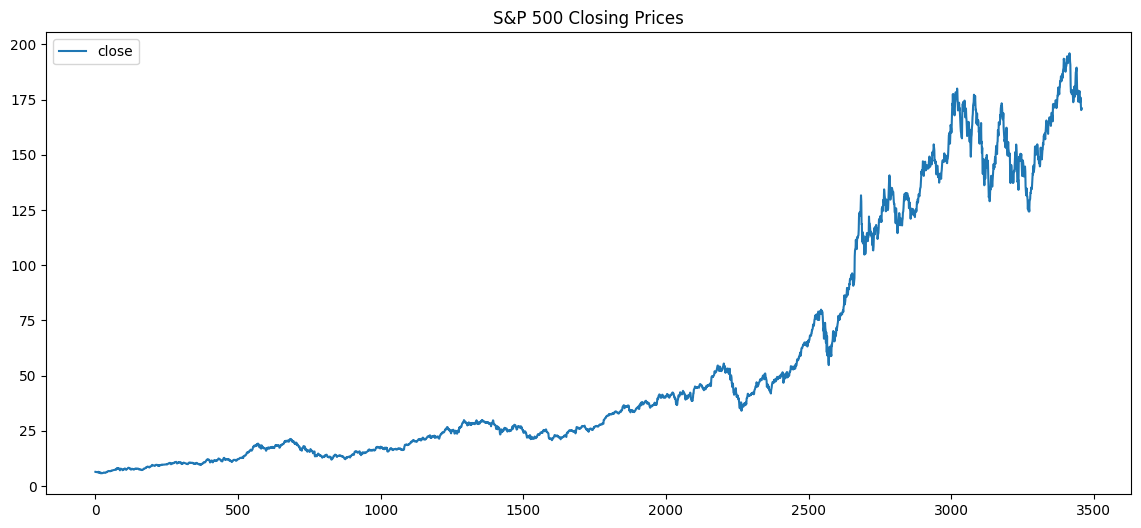

In [351]:
sp500.plot.line(y='close', figsize=(14, 6), title='S&P 500 Closing Prices', use_index=True);

In [352]:
sp500.columns

Index(['date', 'open', 'high', 'low', 'close', 'volume', 'cpi',
       'unemployment rate', '10-year treasury', 'tomorrow', 'target'],
      dtype='object')

In [224]:
sp500[sp500.isnull().any(axis=1)]

,date,open,high,low,close,volume,cpi,unemployment rate,10-year treasury,tomorrow,target
3458,2023-09-29,4328.180176,4333.149902,4274.859863,4288.049805,3865960000,3.243376,3.8,4.59,NaN,0


In [353]:
sp500.set_index('date', inplace=True)
sp500.head()

,open,high,low,close,volume,cpi,unemployment rate,10-year treasury,tomorrow,target
date,,,,,,,,,,
2010-01-04,6.461439,6.493833,6.429651,6.478998,493729600,-0.156725,9.8,3.85,6.490200,1
2010-01-05,6.496861,6.526832,6.455990,6.490200,601904800,-0.155428,9.8,3.77,6.386963,0
2010-01-06,6.490199,6.515932,6.380303,6.386963,552160000,-0.154130,9.8,3.85,6.375157,0
2010-01-07,6.410578,6.418147,6.328837,6.375157,477131200,-0.152833,9.8,3.85,6.417540,1
2010-01-08,6.366679,6.418146,6.329140,6.417540,447610800,-0.151535,9.8,3.83,6.360929,0


In [354]:
from sklearn.ensemble import RandomForestClassifier

model  = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=1)

train  = sp500.iloc[:int(len(sp500)*0.99)]
test  = sp500.iloc[int(len(sp500)*0.99):]

predictors  = ['open', 'high', 'low', 'close', 'volume', 'cpi', 'unemployment rate', '10-year treasury']
target  = 'target'

model.fit(train[predictors], train[target])

RandomForestClassifier(min_samples_split=100, random_state=1)

In [355]:
from sklearn.metrics import precision_score, recall_score, accuracy_score

preds  = model.predict(test[predictors])

In [356]:
preds = pd.Series(preds, index=test.index)

In [357]:
precision_score(test[target], preds)

0.5

# Plotting

In [358]:
combined = pd.concat([test['target'], preds], axis=1).dropna()
combined = combined.rename(columns={0: 'predicted'})


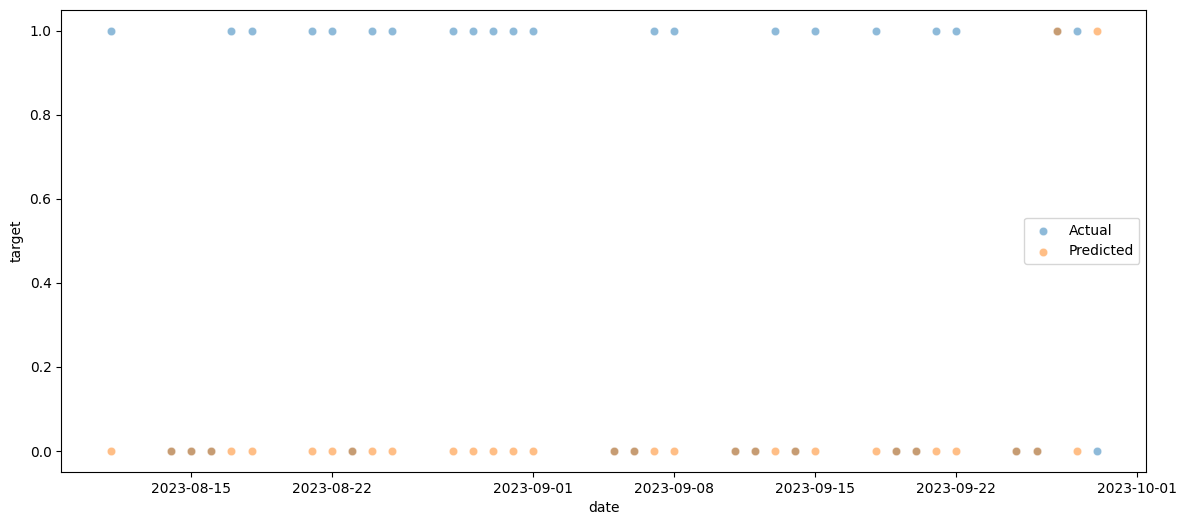

In [359]:
ax = sns.scatterplot(x="date", y='target', data=combined, alpha=0.5)
ax = sns.scatterplot(x="date", y='predicted', data=combined, alpha=0.5)
fig = ax.get_figure()
fig.set_size_inches(14,6)
plt.legend(labels=['Actual', 'Predicted'])

One thing to note about our prediction is that most of the time we say it will increase however it decreases. and actually for last dates this is kind of reversed

In [376]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train[target])
    preds = model.predict_proba(test[predictors])[:,1]
    preds[preds > 0.5] = 1
    preds[preds <= 0.5] = 0
    preds = pd.Series(preds, index=test.index, name='predicted')
    combined = pd.concat([test['target'], preds], axis=1)
    return combined

In [361]:
def backtest(data, model, predictors, start=1500, step=125):
    all_predictions = []
    
    for i in range(start, data.shape[0], step):
        train = data.iloc[:i].copy()
        test = data.iloc[i:i+step].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)
    
    return pd.concat(all_predictions)
        

In [362]:
predictions = backtest(sp500, model, predictors)

In [363]:
predictions.predicted.value_counts()

predicted
0    1295
1     664
Name: count, dtype: int64

In [364]:
precision_score(predictions.target, predictions.predicted)
# 52% of the time we are correct when we predict the market will go up
# precision_score = TP / (TP + FP)

0.5376506024096386

In [365]:
# as an benchmark, let's see what happens if we just predict the market will go up every day
predictions.target.value_counts() / predictions.shape[0]
# we see that actually we are better if we just predict the market will go up every day
# So, our model acutally is not very good

target
1    0.532925
0    0.467075
Name: count, dtype: float64

In [366]:
accuracy_score(predictions.target, predictions.predicted)

0.49259826442062277

# Adding more predictors to our model.

In [367]:
# Function to perform simplified feature engineering
def generate_features(data):
    data = data.copy()
    # Price-based Features
    data['ma20'] = data['close'].rolling(window=20).mean()
    data['ma50'] = data['close'].rolling(window=50).mean()
    data['rate_of_change'] = data['close'].pct_change()
    data['volatility'] = data['close'].pct_change().rolling(window=20).std()

    # Volume-based Features
    data['avg_volume'] = data['volume'].rolling(window=20).mean()
    data['relative_volume'] = data['volume'] / data['avg_volume']

    # Technical Indicators
    data['rsi'] = 100 - (100 / (1 + data['close'].rolling(window=14).apply(lambda x: np.where(x.diff() > 0, x.diff(), 0).sum() / np.where(x.diff() < 0, -x.diff(), 0).sum())))
    data['macd_line'] = data['close'].rolling(window=12).mean() - data['close'].rolling(window=26).mean()
    data['stochastic_oscillator'] = 100 * (data['close'] - data['close'].rolling(window=14).min()) / (data['close'].rolling(window=14).max() - data['close'].rolling(window=14).min())

    # Price Rate of Change
    data['price_rate_of_change_5'] = data['close'].pct_change(5)
    data['price_rate_of_change_20'] = data['close'].pct_change(20)

    # Lagged Features
    data['lag_close_1'] = data['close'].shift(1)
    data['lag_volume_1'] = data['volume'].shift(1)

    # Day-of-Week Features
    data['day_of_week'] = data.index.dayofweek

    # Moving Averages Cross-Over
    data['ma_cross_over'] = np.where(data['ma20'] > data['ma50'], 1, 0)


    horizons = [2, 5, 60, 250, 1000]

    for horizon in horizons:
        rolling_averages = data['close'].rolling(horizon).mean()

        ratio_column = f"close_ratio_{horizon}"
        data[ratio_column] = data['close'] / rolling_averages

        trend_column = f"trend_{horizon}"
        data[trend_column] = data.target.shift(1).rolling(horizon).sum()

    return data.dropna()

# Apply simplified feature engineering to your DataFrame
sp500 = generate_features(sp500)

In [368]:
# Function to perform feature engineering on macroeconomic data
def generate_macro_features(data):
    data = data.copy()  # Create a copy of the data
    # Price-based Features
    data['10yr_treasury_bill_ma'] = data['10-year treasury'].rolling(window=20).mean()
    data['inflation_rate_change'] = data['cpi'].pct_change()
    data['unemployment_rate_rolling'] = data['unemployment rate'].rolling(window=14).mean()

    # Lagged Features
    data['lag_10yr_treasury_bill_1'] = data['10-year treasury'].shift(1)
    data['lag_inflation_rate_1'] = data['cpi'].shift(1)
    data['lag_unemployment_rate_1'] = data['unemployment rate'].shift(1)

    # Other Macro Features (add more as needed)
    data['10yr_treasury_bill_diff'] = data['10-year treasury'].diff()
    data['inflation_rate_squared'] = data['cpi'] ** 2

    return data.dropna()

# Assuming macroeconomic_data is your DataFrame with columns '10yr_treasury_bill', 'inflation_rate', 'unemployment_rate'
sp500 = generate_macro_features(sp500)

In [369]:
sp500.columns

Index(['open', 'high', 'low', 'close', 'volume', 'cpi', 'unemployment rate',
       '10-year treasury', 'tomorrow', 'target', 'ma20', 'ma50',
       'rate_of_change', 'volatility', 'avg_volume', 'relative_volume', 'rsi',
       'macd_line', 'stochastic_oscillator', 'price_rate_of_change_5',
       'price_rate_of_change_20', 'lag_close_1', 'lag_volume_1', 'day_of_week',
       'ma_cross_over', 'close_ratio_2', 'trend_2', 'close_ratio_5', 'trend_5',
       'close_ratio_60', 'trend_60', 'close_ratio_250', 'trend_250',
       'close_ratio_1000', 'trend_1000', '10yr_treasury_bill_ma',
       'inflation_rate_change', 'unemployment_rate_rolling',
       'lag_10yr_treasury_bill_1', 'lag_inflation_rate_1',
       'lag_unemployment_rate_1', '10yr_treasury_bill_diff',
       'inflation_rate_squared'],
      dtype='object')

In [370]:
new_predictors = ['cpi', 'unemployment rate',
       '10-year treasury', 'ma20', 'ma50',
       'rate_of_change', 'volatility', 'avg_volume', 'relative_volume', 'rsi',
       'macd_line', 'stochastic_oscillator', 'price_rate_of_change_5',
       'price_rate_of_change_20', 'lag_close_1', 'lag_volume_1', 'day_of_week',
       'ma_cross_over', 'close_ratio_2', 'trend_2', 'close_ratio_5', 'trend_5',
       'close_ratio_60', 'trend_60', 'close_ratio_250', 'trend_250',
       'close_ratio_1000', 'trend_1000', '10yr_treasury_bill_ma',
       'inflation_rate_change', 'unemployment_rate_rolling',
       'lag_10yr_treasury_bill_1', 'lag_inflation_rate_1',
       'lag_unemployment_rate_1', '10yr_treasury_bill_diff',
       'inflation_rate_squared']

In [371]:
predictions = backtest(sp500, model, new_predictors)

In [372]:
predictions.predicted.value_counts()

predicted
0    511
1    428
Name: count, dtype: int64

In [373]:
precision_score(predictions.target, predictions.predicted)

0.530373831775701

In [374]:
predictions.target.value_counts() / predictions.shape[0]

target
1    0.523962
0    0.476038
Name: count, dtype: float64

In [375]:
accuracy_score(predictions.target, predictions.predicted)

0.503727369542066

                      Feature  Importance
5              rate_of_change    0.045089
9                         rsi    0.042874
24            close_ratio_250    0.042193
29      inflation_rate_change    0.040703
18              close_ratio_2    0.040065
15               lag_volume_1    0.039903
26           close_ratio_1000    0.038199
8             relative_volume    0.037923
10                  macd_line    0.037907
20              close_ratio_5    0.037234
13    price_rate_of_change_20    0.037118
6                  volatility    0.034137
12     price_rate_of_change_5    0.033885
22             close_ratio_60    0.033589
32       lag_inflation_rate_1    0.030304
14                lag_close_1    0.029742
0                         cpi    0.029458
7                  avg_volume    0.029285
4                        ma50    0.027751
34    10yr_treasury_bill_diff    0.027617
2            10-year treasury    0.026469
30  unemployment_rate_rolling    0.025561
28      10yr_treasury_bill_ma    0

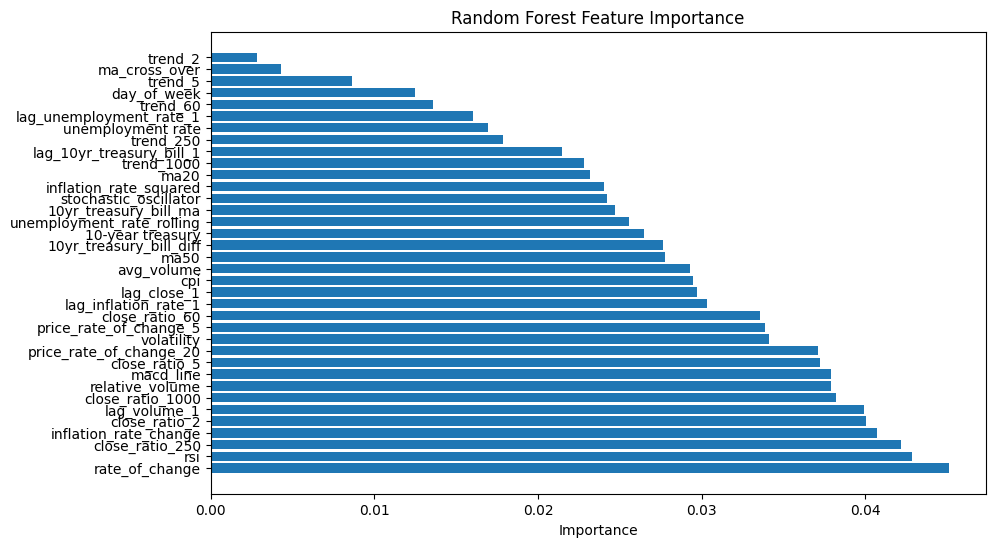

In [377]:
# Get feature importances
feature_importance = pd.DataFrame({'Feature': new_predictors, 'Importance': model.feature_importances_})
feature_importance.sort_values(by='Importance', ascending=False, inplace=True)

# Display or plot the feature importances
print(feature_importance)

# Plot bar chart of feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'])
plt.xlabel('Importance')
plt.title('Random Forest Feature Importance')
plt.show()

Selected Features: Index(['10-year treasury', 'rate_of_change', 'volatility', 'avg_volume',
       'relative_volume', 'rsi', 'macd_line', 'price_rate_of_change_5',
       'price_rate_of_change_20', 'lag_close_1', 'lag_volume_1',
       'close_ratio_2', 'close_ratio_5', 'close_ratio_60', 'close_ratio_250',
       'close_ratio_1000', 'inflation_rate_change', 'lag_inflation_rate_1'],
      dtype='object')


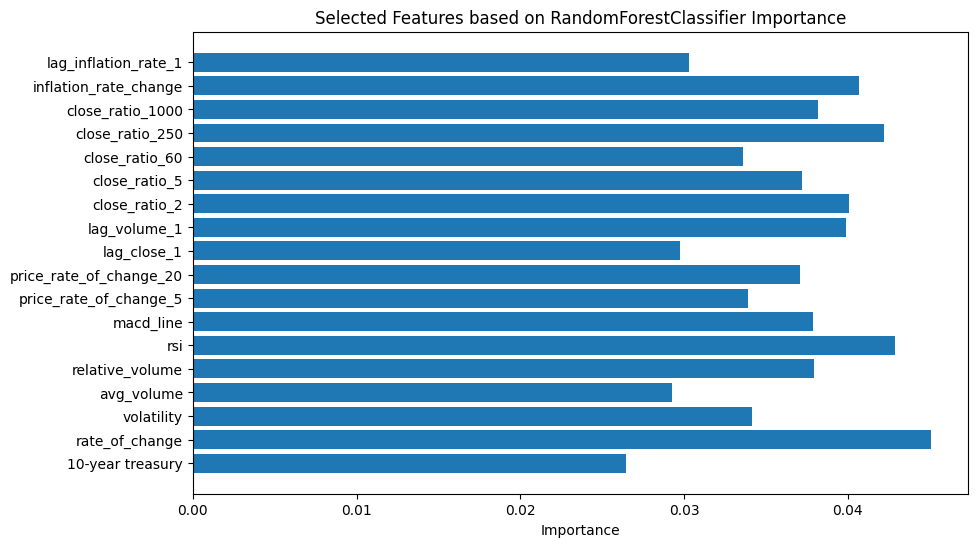

In [378]:
from sklearn.feature_selection import SelectFromModel


# Compute the mean of the feature importances
# mean_importance = model.feature_importances_.mean()
# median_importance = np.median(model.feature_importances_)
# print(f"Mean Feature Importance: {mean_importance}")
# print(f"Median Feature Importance: {median_importance}")

# Create a SelectFromModel instance
sfm = SelectFromModel(model, threshold="median")  # You can adjust the threshold as needed

# Fit the SelectFromModel instance and transform the features
X_selected = sfm.fit_transform(sp500[new_predictors], sp500[target])

# Get selected feature names
selected_features = sp500[new_predictors].columns[sfm.get_support()]

# Display or plot the selected feature names
print("Selected Features:", selected_features)

# Plot bar chart of feature importances for selected features
plt.figure(figsize=(10, 6))
plt.barh(selected_features, model.feature_importances_[sfm.get_support()])
plt.xlabel('Importance')
plt.title('Selected Features based on RandomForestClassifier Importance')
plt.show()


In [379]:
predictions = backtest(sp500, model, selected_features)

In [380]:
predictions.predicted.value_counts()

predicted
1.0    515
0.0    424
Name: count, dtype: int64

In [381]:
precision_score(predictions.target, predictions.predicted)

0.5281553398058253

In [382]:
predictions.target.value_counts() / predictions.shape[0]

target
1    0.523962
0    0.476038
Name: count, dtype: float64

In [383]:
accuracy_score(predictions.target, predictions.predicted)

0.5069222577209798

# Improving our model